In [1]:
import os
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
import rdkit
print(rdkit.__version__)

from src.utils import save_json, get_compound_hash, get_reaction_hash, postsanitize_smiles, neutralise_charges, smarts_to_sub_smiles, sub_smiles_to_smarts
from src.post_processing import Enzyme, DatabaseEntry
from collections import Counter, defaultdict
import json
import pandas as pd
import csv

def sanitize(reactants, products):
    return postsanitize_smiles(reactants)[0], postsanitize_smiles(products)[0]

def neutralize(reactants, products):
    reactants = [Chem.MolToSmiles(neutralise_charges(Chem.MolFromSmiles(elt, sanitize=False))) for elt in reactants]
    products = [Chem.MolToSmiles(neutralise_charges(Chem.MolFromSmiles(elt, sanitize=False))) for elt in products]
    return reactants, products

def get_rhash(reactants, products):
    reactants_hash_stoich = list(Counter([get_compound_hash(elt)[0] for elt in reactants]).items())
    products_hash_stoich = list(Counter([get_compound_hash(elt)[0] for elt in products]).items())
    rhash = get_reaction_hash(reactants_hash_stoich, products_hash_stoich)
    return rhash

2023.03.2


In [64]:
# Load known reactions
with open("../data/mapping/known_rxns_swissprot_enzymes_240310.json", 'r') as f:
    known_rxns = json.load(f)

In [68]:
# Load min rule mappings

min_mappings = {}
with open("../data/mapping/mapping_swissprot_min_rules_enforce_cof.csv", 'r') as f:
    r = csv.reader(f)

    for line in r:
        min_mappings[line[0]] = tuple(line[1:])



In [73]:
# Load rules

min_rules = pd.read_csv('../data/mapping/minimal1224_all_uniprot.tsv', sep='\t')
min_rules.set_index('Name', inplace=True)
min_rules.head(20)

,Reactants,SMARTS,Products,Comments
Name,,,,
rule0001,Any;Any,[#6:1]-[#8:2].[#8:3]>>[#6:1]-[#8:3].[#8:2],Any;Any,A0A060PLD9;A0A0P0YNP7;A0A0P9RZM9;A1XCQ0;A3E242...
rule0002,Any;NAD_CoF,[#6:1]-[#8:2].[#6:3]1:[#6:4]:[#6:5]:[#6:6]:[#7...,NADH_CoF;Any,A0A023RBJ1;A0A060KZ16;A0A060TBM3;A0A072UJB3;A0...
rule0003,NADH_CoF;Any,[#6:1]1=[#6:2]-[#7:3]-[#6:4]=[#6:5]-[#6:6]-1.[...,Any;NAD_CoF,A0A023RBJ1;A0A060KZ16;A0A060TBM3;A0A072UJB3;A0...
rule0004,Any;NADH_CoF;O2,[#6:1].[#6:2]1=[#6:3]-[#7:4]-[#6:5]=[#6:6]-[#6...,Any;NAD_CoF;WATER,A0A1P8W705;A0A250DUW2;A1Z745;A5HMH6;A5HMH7;A5H...
rule0005,Any;NAD_CoF;WATER,[#6:1]-[#8:2].[#6:3]1:[#6:4]:[#6:5]:[#6:6]:[#7...,Any;NADH_CoF;O2,A0A1P8W705;A0A250DUW2;A1Z745;A5HMH6;A5HMH7;A5H...
rule0006,Any;Any,[#6:1]-[#8:2].[#8:3]>>[#6:1]-[#8:3].[#8:2],Any;WATER,A0A023J5W7;A0A023MIF8;A0A024FS29;A0A024FSF5;A0...
rule0007,Any;WATER,[#6:1]-[#8:2].[#8:3]>>[#6:1]-[#8:3].[#8:2],Any;Any,A0A023J5W7;A0A023MIF8;A0A024FS29;A0A024FSF5;A0...
rule0008,Any;GLUCOSYL_ACCEPTOR_CoF,[#6:1]-[#8:2].[#8:3]>>[#6:1]-[#8:3].[#8:2],GLUCOSYL_DONOR_CoF;Any,A0A023NFQ4;A0A023NGA8;A0A059ZV61;A0A0B5WYD4;A0...
rule0009,GLUCOSYL_DONOR_CoF;Any,[#6:1]-[#8:2].[#8:3]>>[#6:1]-[#8:3].[#8:2],Any;GLUCOSYL_ACCEPTOR_CoF,A0A023NFQ4;A0A023NGA8;A0A059ZV61;A0A0B5WYD4;A0...


In [87]:
min_rules.loc['rule0002', 'SMARTS']

'[#6:1]-[#8:2].[#6:3]1:[#6:4]:[#6:5]:[#6:6]:[#7+:7]:[#6:8]:1>>[#6:3]1=[#6:8]-[#7+0:7]-[#6:6]=[#6:5]-[#6:4]-1.[#6:1]=[#8:2]'

In [75]:
for k,v in min_mappings.items():
    if 'rule0013' in v:
        print(k, v)
        break

R74c8e872863878b438386373a6a4bad397738830bd43a509aad498bb50aed971 ('rule0013',)


In [81]:
rhash = 'R74c8e872863878b438386373a6a4bad397738830bd43a509aad498bb50aed971'
rule = 'rule0013'
rxn = Chem.rdChemReactions.ReactionFromSmarts(min_rules.loc[rule, 'SMARTS'])
kr = known_rxns[rhash]['smarts']
reactants, products = smarts_to_sub_smiles(kr)
rmols = [Chem.MolFromSmiles(smi) for smi in reactants]
rxn.RunReactants(rmols)

((<rdkit.Chem.rdchem.Mol at 0x7f48bde82d50>,
  <rdkit.Chem.rdchem.Mol at 0x7f48bde82e70>),
 (<rdkit.Chem.rdchem.Mol at 0x7f48bde82930>,
  <rdkit.Chem.rdchem.Mol at 0x7f48bdd4ec90>))

In [3]:
keys = list(known_rxns.keys())

In [17]:
i = 0

['*NC(Cc1ccc(O)cc1)C(*)=O', 'Nc1ncnc2c1ncn2C1OC(COP(=O)(O)OP(=O)(O)OP(=O)(O)O)C(O)C1O>>*NC(Cc1ccc(OP(=O)(O)OCC2OC(n3cnc4c(N)ncnc43)C(O)C2O)cc1)C(*)=O', 'O=P(O)(O)OP(=O)(O)O']


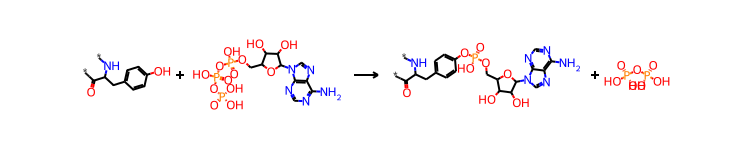

In [57]:

# Does AllChem.ReactionFromSmarts maintain order of molecules
# found in smarts string? Yea.

smarts = known_rxns[keys[i]]['smarts']
print(smarts.split("."))
i += 1
rxn = AllChem.ReactionFromSmarts(smarts, useSmiles=True)
rxn

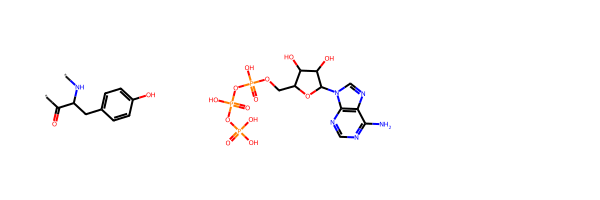

In [58]:
mols = [r for r in rxn.GetReactants()]# + [p for p in rxn.GetProducts()]
Draw.MolsToGridImage(mols)

In [32]:
Draw.MolsToGridImage([p for p in rxn.GetProducts()])

RuntimeError: Pre-condition Violation
	getExplicitValence() called without call to calcExplicitValence()
	Violation occurred on line 306 in file Code/GraphMol/Atom.cpp
	Failed Expression: d_explicitValence > -1
	RDKIT: 2023.03.2
	BOOST: 1_78


In [21]:
mols

In [ ]:
'''
- Assign rules to reactions
- Split reactions into 0, 1, >1 operator mappings
- Take 1 mapped ones, run protected reactions to get indices
    of reactions center on lhs
- Assign atommapnum 1: to reaction center on lhs
- Re-run reaction to produce products with atommapnums on reaction center
- Convert into smiles/smarts reaction string
'''

In [86]:
from itertools import chain
matches = ((0,1,2), (2,3,4))
set(chain(*matches))

{0, 1, 2, 3, 4}

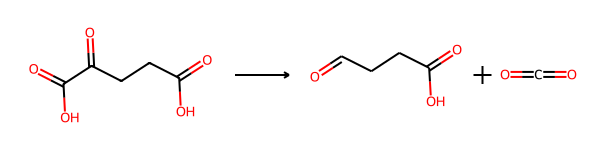

In [3]:
akg = 'O=C(O)CCC(=O)C(=O)O'
co2 = 'O=C=O'
decarb_akg = 'O=C(O)CCC(=O)'
rxn_smarts = f"{akg}>>{decarb_akg}.{co2}"
AllChem.ReactionFromSmarts(rxn_smarts, useSmiles=True)